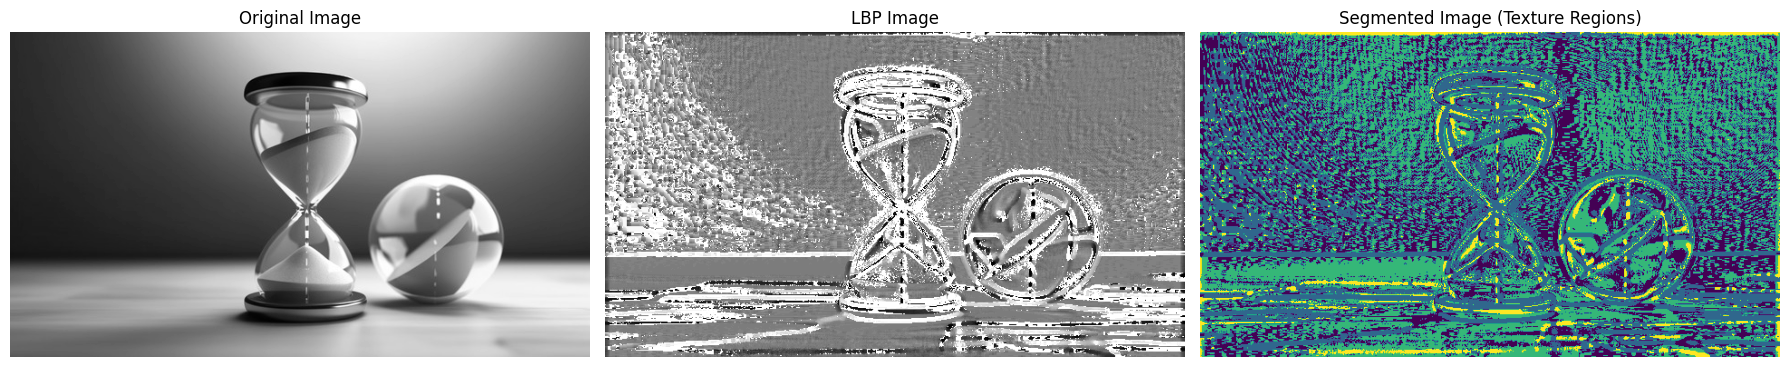

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans

# 1. Load the image
image = cv2.imread(r'image_path', cv2.IMREAD_GRAYSCALE)

# 2. Compute the LBP features
# Parameters for LBP
radius = 5
n_points = 8 * radius

# Compute LBP
lbp_image = local_binary_pattern(image, n_points, radius, method="uniform")

# Normalize LBP image to 0-255
lbp_image_normalized = np.uint8(255 * (lbp_image - lbp_image.min()) / (lbp_image.max() - lbp_image.min()))

# 3. Flatten the LBP features for clustering
height, width = lbp_image.shape
lbp_flat = lbp_image_normalized.reshape(-1, 1)

# 4. Classify pixels into regions using K-Means
num_clusters = 4  # Define the number of texture regions
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(lbp_flat)

# Reshape labels to the image shape
segmented_image = labels.reshape(height, width)

# 5. Visualize the results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axs[0].imshow(image, cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")

# LBP Image
axs[1].imshow(lbp_image_normalized, cmap="gray")
axs[1].set_title("LBP Image")
axs[1].axis("off")

# Segmented Image
axs[2].imshow(segmented_image, cmap="viridis")
axs[2].set_title("Segmented Image (Texture Regions)")
axs[2].axis("off")

plt.tight_layout()
plt.show()


Number of training images: 1027
Number of testing images: 256


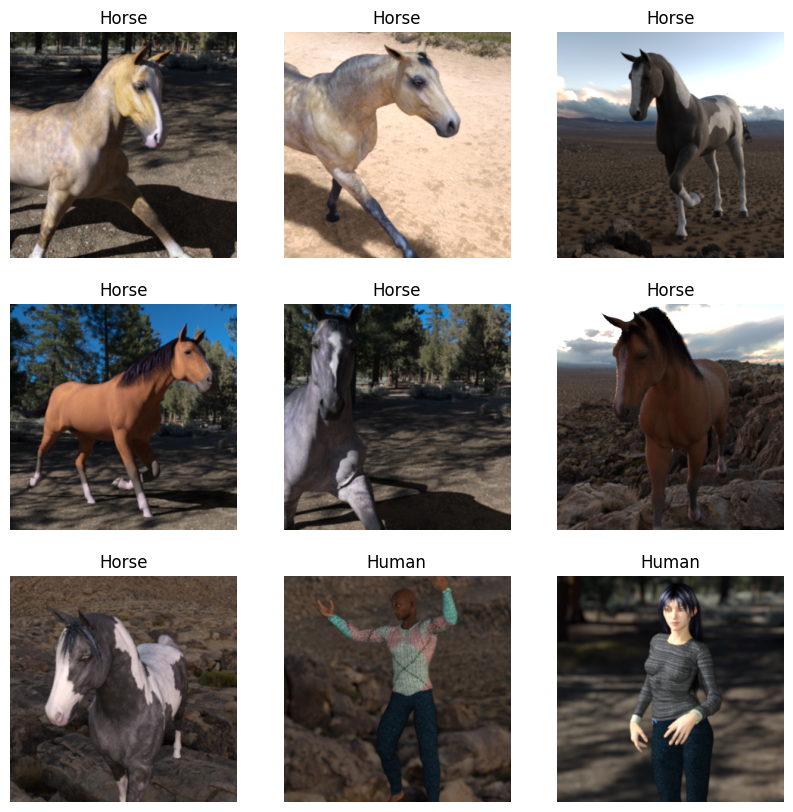

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 961ms/step - accuracy: 0.5008 - loss: 0.7186 - val_accuracy: 0.7070 - val_loss: 0.5379
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 817ms/step - accuracy: 0.6387 - loss: 0.6438 - val_accuracy: 0.8047 - val_loss: 0.4561
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 778ms/step - accuracy: 0.7027 - loss: 0.6012 - val_accuracy: 0.8477 - val_loss: 0.3882
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 768ms/step - accuracy: 0.7281 - loss: 0.5628 - val_accuracy: 0.8516 - val_loss: 0.3476
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 771ms/step - accuracy: 0.7646 - loss: 0.5277 - val_accuracy: 0.8516 - val_loss: 0.3323


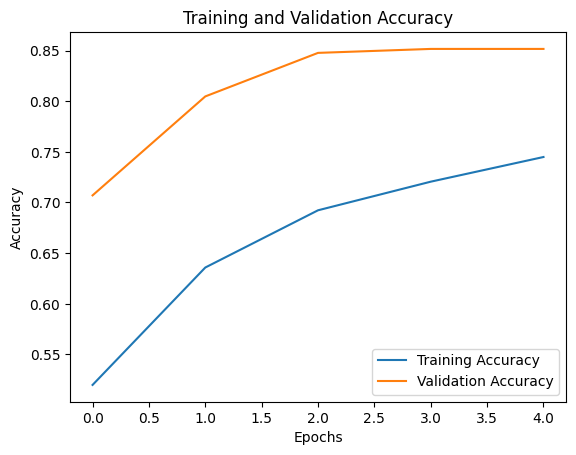

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 620ms/step - accuracy: 0.8744 - loss: 0.2984
Test accuracy: 0.8515625


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# 1. Load the dataset
(ds_train, ds_test), ds_info = tfds.load('horses_or_humans', split=['train', 'test'], with_info=True, as_supervised=True)

# 2. View the number of testing and training images
train_size = ds_info.splits['train'].num_examples
test_size = ds_info.splits['test'].num_examples
print(f"Number of training images: {train_size}")
print(f"Number of testing images: {test_size}")

# 3. Plot some images
def plot_samples(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Horse" if label == 0 else "Human")
    plt.show()

# Display first 9 images from the training dataset
plot_samples(ds_train)

# 4. Normalizing the training data and preprocessing the dataset
def preprocess_data(dataset, batch_size=32):
    def normalize_image(image, label):
        image = tf.image.resize(image, (128, 128))  # Resize images to 128x128
        image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
        return image, label

    return dataset.map(normalize_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = preprocess_data(ds_train)
test_ds = preprocess_data(ds_test)

# 5. Build a Convolutional Neural Network (ResNet) for classification
base_model = tf.keras.applications.ResNet50(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the ResNet layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification (horse or human)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 6. Train the CNN model and show the accuracy
history = model.fit(train_ds, epochs=5, validation_data=test_ds)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# 7. Show the testing accuracy
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc}")
